# 1. Convert from csv into pcd

In [75]:
import pandas as pd
import open3d
import numpy as np
from utilities.classification import classify_from_obb_and_plane
from utilities.obb import get_horizontal_obb
from utilities.draw_id import *
from os import path
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm

# 1.1 Inspect dataset

Show part of the data, Frame 2552

In [30]:
df = pd.read_csv(f"./data_IU_final/raw_data_consecutive/192.168.26.26_2020-11-25_20-01-45_frame-2552.csv", sep=';')
print(df.head())


           X          Y         Z   DISTANCE  INTENSITY  POINT_ID  RETURN_ID  \
0 -12.375972  17.461351 -0.010019  21.402420       17.0       0.0        0.0   
1 -12.423131  17.948128 -0.010199  21.828182       19.0       1.0        0.0   
2 -12.409833  18.369034 -0.011275  22.168119       17.0       2.0        0.0   
3 -12.355803  18.729197 -0.011388  22.437666       17.0       3.0        0.0   
4 -12.525309  19.439358 -0.012687  23.125141       21.0       4.0        0.0   

   AMBIENT     TIMESTAMP  
0      1.0  1.602860e+18  
1      1.0  1.602860e+18  
2      6.0  1.602860e+18  
3      0.0  1.602860e+18  
4      1.0  1.602860e+18  


Check the datatype, min max value

In [31]:
df.describe()

,X,Y,Z,DISTANCE,INTENSITY,POINT_ID,RETURN_ID,AMBIENT,TIMESTAMP
count,18636.000000,18636.000000,18636.000000,18636.000000,18636.000000,18636.000000,18636.0,18636.000000,1.863600e+04
mean,0.690138,17.545852,0.381140,18.924341,21.016688,11871.580972,0.0,6.579899,1.602860e+18
std,6.744008,9.404670,2.578503,9.535371,12.583493,6880.846423,0.0,5.882099,1.015391e+08
min,-34.166534,4.545660,-2.421817,4.597664,5.000000,0.000000,0.0,0.000000,1.602860e+18
25%,-3.988498,13.703383,-1.509079,14.589888,13.000000,5952.750000,0.0,3.000000,1.602860e+18
50%,2.050881,15.896074,-0.366837,17.207082,17.000000,11615.500000,0.0,5.000000,1.602860e+18
75%,5.843137,17.994161,1.603792,20.324317,25.000000,17760.250000,0.0,8.000000,1.602860e+18
max,13.096910,99.657547,19.282883,100.226738,285.000000,24199.000000,0.0,119.000000,1.602860e+18


In [32]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18636 entries, 0 to 18635
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          18636 non-null  float64
 1   Y          18636 non-null  float64
 2   Z          18636 non-null  float64
 3   DISTANCE   18636 non-null  float64
 4   INTENSITY  18636 non-null  float64
 5   POINT_ID   18636 non-null  float64
 6   RETURN_ID  18636 non-null  float64
 7   AMBIENT    18636 non-null  float64
 8   TIMESTAMP  18636 non-null  float64
dtypes: float64(9)
memory usage: 1.3 MB
None


# 1.2. Preprocessing data

We filter out the point which in the distance from 5 to 200 m

In [36]:
def check_dataframe(id_frame):

    df = pd.read_csv(f"./data_IU_final/raw_data_consecutive/192.168.26.26_2020-11-25_20-01-45_frame-{id_frame}.csv", sep=';')

    # Extract XYZ
    #==== remove null-data of xyz column
    df = df[~df[['X', 'Y', 'Z', 'DISTANCE']].isna().all(axis=1)]
    df = df[(df['DISTANCE'] >= 5) & (df['DISTANCE'] <= 250)]
    number_of_point = df.shape[0]
    points = df[['X', 'Y', 'Z']].to_numpy()

    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Save as PCD
    o3d.io.write_point_cloud(f"./data_IU_final/sanity/pcd/{id_frame}.pcd", pcd)
    return f"./data_IU_final/sanity/pcd/{id_frame}.pcd", number_of_point

Function to visualize data point cloud

In [ ]:
def visualize_pcd_distance(path_pcd, frame_id):    

    # -----------------------------
    # Load PCD file
    # -----------------------------
    pcd = o3d.io.read_point_cloud(path_pcd)
    points = np.asarray(pcd.points)

    # -----------------------------
    # Choose reference point
    # (0,0,0) is typical, but you can change it
    # -----------------------------
    origin = np.array([0.0, 0.0, 0.0])

    # -----------------------------
    # Compute distance for each point
    # -----------------------------
    distances = np.linalg.norm(points - origin, axis=1)
    distances = distances ** 0.3   # 0.3 makes colors change faster

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_axis_off()
    ax.dist = 1  # zoom out
    ax.set_xlim(0,20)
    ax.set_ylim(0,20)
    ax.set_zlim(0,25)
    ax.view_init(elev=30, azim=-30)
    
    scatter = ax.scatter(
        points[:, 0], points[:, 1], points[:, 2],
        c=distances,
        cmap='viridis',
        s=1
    )

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Distance from origin")

    # Camera angle

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Point Cloud Colored by Distance FRANE ID: " + str(frame_id))

    plt.savefig(f"./data_IU_final/sanity/2d_image/{frame_id}.png", dpi=300, bbox_inches='tight')
    plt.close()

    #plt.show()

We process first 100 frames from 1849 to 1950
- we visualize first 5 frames to ensure that the coordinate of the system are consistent through frame
- we count the number of point in each frame and visualize it

In [52]:
list_id = list(range(1849,1950))
number_frame = []
for id_frame in tqdm(list_id):
    path_pcd, num = check_dataframe(id_frame)
    if id_frame < 1854:
        visualize_pcd_distance(path_pcd, id_frame)
    number_frame.append(num)

100%|██████████| 101/101 [00:23<00:00,  4.24it/s]


The code cell below visualize first 5 frames, it shows that the coordiantes are consistent through frame

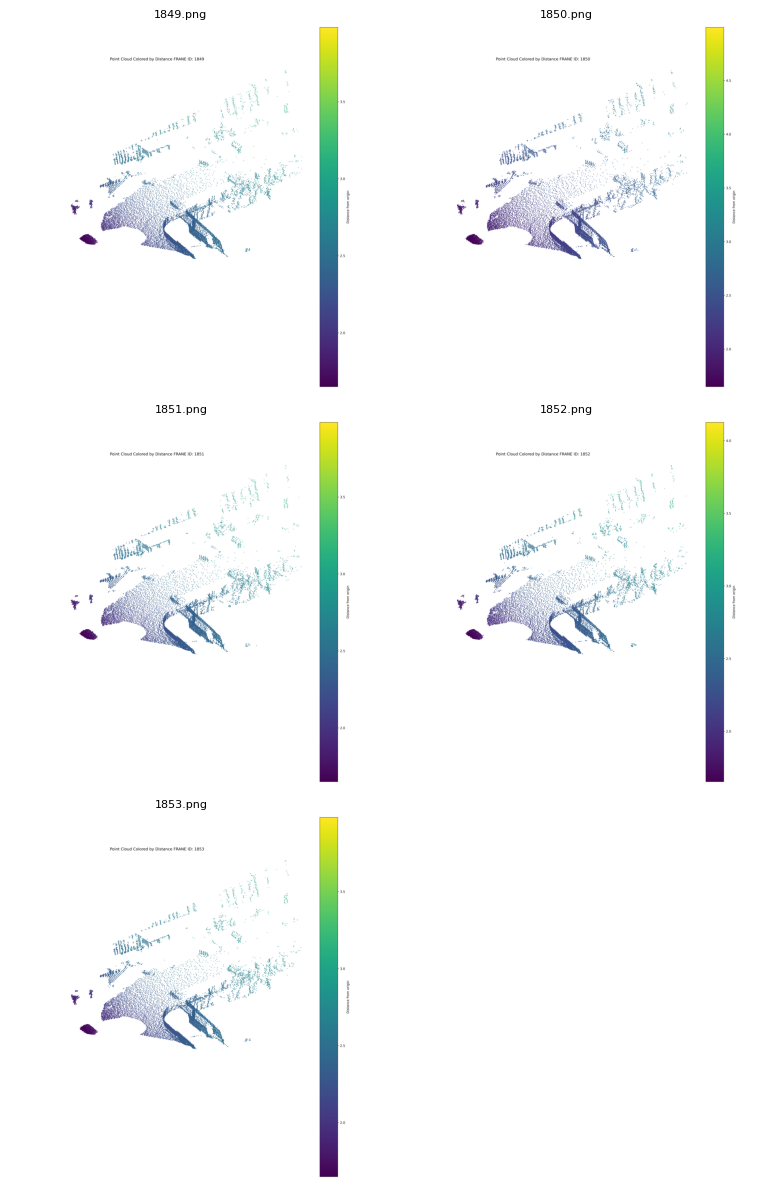

In [57]:
import os
import math
# Path to your image folder
img_dir = "./data_IU_final/sanity/2d_image"

# List all image files (common extensions)
valid_ext = (".png")

images = [f for f in os.listdir(img_dir) if f.lower().endswith(valid_ext)]
images.sort()  # optional: sort alphabetically

num_images = len(images)
cols = 2  # number of columns you want
rows = math.ceil(num_images / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

# Flatten axes for easy iteration
axes = axes.flatten()

for ax, img_name in zip(axes, images):
    img_path = os.path.join(img_dir, img_name)
    img = Image.open(img_path)

    ax.imshow(img)
    ax.set_title(img_name, fontsize=8)
    ax.axis("off")

# Hide any unused subplots
for ax in axes[num_images:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [67]:
min(number_frame)

18409

We then visualize the distribution of the number of points each frame, it show that the devitation is about 0.8% of the total points show that the LiDAR sensor records well.

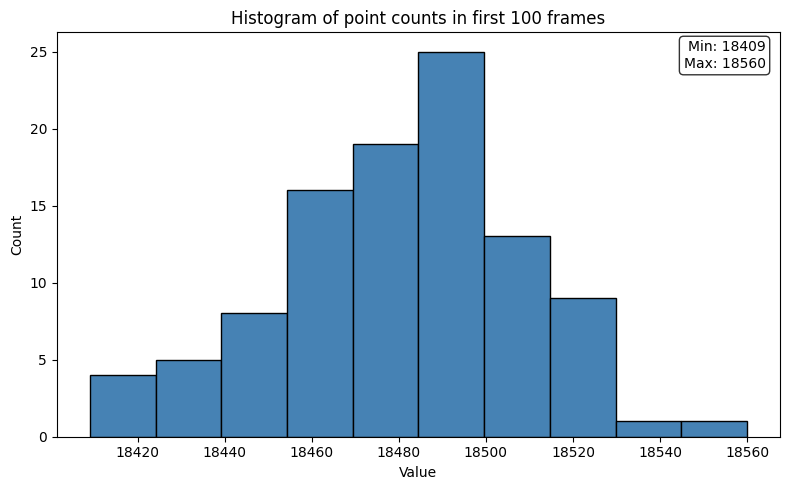

In [73]:
import matplotlib.pyplot as plt

xmin = min(number_frame)
xmax = max(number_frame)
padding = (xmax - xmin) * 0.05

plt.figure(figsize=(8, 5))
plt.hist(number_frame, bins=10, color='steelblue', edgecolor='black')

plt.xlim(xmin - padding, xmax + padding)

plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram of point counts in first 100 frames")
text = f"Min: {xmin}\nMax: {xmax}"
plt.gca().text(
    0.98, 0.98, text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()